# Web Scraping
Basic tutorial using BeautifulSoup to extract forecast data for a particular city in U.S. from weather.gov website.  
Based on [this tutorial](https://www.dataquest.io/blog/web-scraping-python-using-beautiful-soup/)

In [1]:
# Importing required libraries

import requests
from urllib.request import urlopen

from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pymongo import MongoClient

In [2]:
# Defining the website URL and query parameters for the analysis
SITE_URL = "https://forecast.weather.gov/"
PAGE_URL = "{site_url}/MapClick.php?lat={lat}&lon={lon}"
LAT = 40.7146
LON = -74.0071

In [3]:
# Creating a connection to MongoDB
client = MongoClient("localhost", 27017)
db = client["weather"]
collection = db["forecast"]

In [4]:
# Downloading and storing in-memory the HTML returned by the weather server
page = requests.get(PAGE_URL.format(site_url = SITE_URL, lat = LAT, lon = LON))
print(page) # Success making the request

<Response [200]>


In [5]:
# HTML content is passed to BeautifulSoup for scraping analysis
soup = BeautifulSoup(page.content, "html.parser")

In [6]:
# Finding by id the tag containing the forecasts
seven_day = soup.find(id = "seven-day-forecast")

In [7]:
# Tags classed with `tombstone-container` contain the different forecast data points
forecast_items = seven_day.find_all(class_ = "tombstone-container")
print(len(forecast_items)) # 9 forecast data points founded

9


In [8]:
# Printint the HTML content for today's forecast
tonight = forecast_items[0]
print(tonight.prettify())

<div class="tombstone-container">
 <p class="period-name">
  Tonight
  <br/>
  <br/>
 </p>
 <p>
  <img alt="Tonight: Patchy drizzle after 3am.  Mostly cloudy, with a low around 63. East wind 8 to 11 mph. " class="forecast-icon" src="DualImage.php?i=nbkn&amp;j=nra&amp;jp=10" title="Tonight: Patchy drizzle after 3am.  Mostly cloudy, with a low around 63. East wind 8 to 11 mph. "/>
 </p>
 <p class="short-desc">
  Mostly Cloudy
  <br/>
  then Patchy
  <br/>
  Drizzle
 </p>
 <p class="temp temp-low">
  Low: 63 °F
 </p>
</div>


In [9]:
# Extracting info from the HTML content for today's forecast

period = tonight.find(class_ = "period-name").get_text()
print(period)

short_desc = tonight.find(class_ = "short-desc").get_text()
print(short_desc)

temp = tonight.find(class_ = "temp").get_text()
print(temp)

Tonight
Mostly Cloudythen PatchyDrizzle
Low: 63 °F


In [10]:
# Accessing to img tag directly by name
img = tonight.find("img")

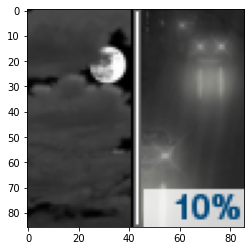

In [11]:
# Extracting and showing a static resource, the image best representing the forecast
f = urlopen(SITE_URL + img["src"])
a = plt.imread(f)
plt.imshow(a)
plt.show()

In [12]:
# Extracting additional metadata from image
desc = img["title"]
print(desc)

Tonight: Patchy drizzle after 3am.  Mostly cloudy, with a low around 63. East wind 8 to 11 mph. 


In [13]:
# Reproducing previous extractions for all data points

periods = [pt.get_text() for pt in seven_day.select(".tombstone-container .period-name")]
print("Periods:", periods)

short_descs = [sd.get_text() for sd in seven_day.select(".tombstone-container .short-desc")]
print("Short descriptions:", short_descs)

temps = [t.get_text() for t in seven_day.select(".tombstone-container .temp")]
print("Temperatures:",temps)

descs = [d["title"] for d in seven_day.select(".tombstone-container img")]
print("Descriptions:", descs)

Periods: ['Tonight', 'Saturday', 'SaturdayNight', 'Sunday', 'SundayNight', 'ColumbusDay', 'MondayNight', 'Tuesday', 'TuesdayNight']
Short descriptions: ['Mostly Cloudythen PatchyDrizzle', 'PatchyDrizzle', 'ChanceShowers andPatchy Fog', 'ShowersLikely', 'ChanceShowers', 'Mostly Cloudy', 'Mostly Cloudy', 'Mostly Cloudy', 'Mostly Cloudy']
Temperatures: ['Low: 63 °F', 'High: 68 °F', 'Low: 63 °F', 'High: 69 °F', 'Low: 63 °F', 'High: 73 °F', 'Low: 63 °F', 'High: 73 °F', 'Low: 63 °F']
Descriptions: ['Tonight: Patchy drizzle after 3am.  Mostly cloudy, with a low around 63. East wind 8 to 11 mph. ', 'Saturday: Patchy drizzle with a slight chance of showers.  Mostly cloudy, with a high near 68. East wind 13 to 15 mph. ', 'Saturday Night: Patchy drizzle and fog with a chance of showers.  Cloudy, with a low around 63. East wind around 16 mph. ', 'Sunday: Showers likely.  Cloudy, with a high near 69. East wind around 15 mph.  Chance of precipitation is 60%. New precipitation amounts between a tenth

In [14]:
# Transforming extracted data to a tabular format
weather_df = pd.DataFrame({
    "period": periods,
    "short_desc": short_descs,
    "temp": temps,
    "desc": descs
})

In [15]:
# Printing tabular forecast data
weather_df

,period,short_desc,temp,desc
0,Tonight,Mostly Cloudythen PatchyDrizzle,Low: 63 °F,Tonight: Patchy drizzle after 3am. Mostly clo...
1,Saturday,PatchyDrizzle,High: 68 °F,Saturday: Patchy drizzle with a slight chance ...
2,SaturdayNight,ChanceShowers andPatchy Fog,Low: 63 °F,Saturday Night: Patchy drizzle and fog with a ...
3,Sunday,ShowersLikely,High: 69 °F,"Sunday: Showers likely. Cloudy, with a high n..."
4,SundayNight,ChanceShowers,Low: 63 °F,Sunday Night: A 40 percent chance of showers. ...
5,ColumbusDay,Mostly Cloudy,High: 73 °F,"Columbus Day: Mostly cloudy, with a high near 73."
6,MondayNight,Mostly Cloudy,Low: 63 °F,"Monday Night: Mostly cloudy, with a low around..."
7,Tuesday,Mostly Cloudy,High: 73 °F,"Tuesday: Mostly cloudy, with a high near 73."
8,TuesdayNight,Mostly Cloudy,Low: 63 °F,"Tuesday Night: Mostly cloudy, with a low aroun..."


In [16]:
# Cleaning temperature column
weather_df["temp_num"] = weather_df["temp"].apply(lambda x: x.split(" ")[1]).astype("int")

In [17]:
# Printing data, again
weather_df

,period,short_desc,temp,desc,temp_num
0,Tonight,Mostly Cloudythen PatchyDrizzle,Low: 63 °F,Tonight: Patchy drizzle after 3am. Mostly clo...,63
1,Saturday,PatchyDrizzle,High: 68 °F,Saturday: Patchy drizzle with a slight chance ...,68
2,SaturdayNight,ChanceShowers andPatchy Fog,Low: 63 °F,Saturday Night: Patchy drizzle and fog with a ...,63
3,Sunday,ShowersLikely,High: 69 °F,"Sunday: Showers likely. Cloudy, with a high n...",69
4,SundayNight,ChanceShowers,Low: 63 °F,Sunday Night: A 40 percent chance of showers. ...,63
5,ColumbusDay,Mostly Cloudy,High: 73 °F,"Columbus Day: Mostly cloudy, with a high near 73.",73
6,MondayNight,Mostly Cloudy,Low: 63 °F,"Monday Night: Mostly cloudy, with a low around...",63
7,Tuesday,Mostly Cloudy,High: 73 °F,"Tuesday: Mostly cloudy, with a high near 73.",73
8,TuesdayNight,Mostly Cloudy,Low: 63 °F,"Tuesday Night: Mostly cloudy, with a low aroun...",63


In [18]:
# What is the mean forecasted temperature?
round(weather_df["temp_num"].mean(), 2)

66.44

Text(0.5, 1.0, 'Forecasted temperature (ºF) for next days')

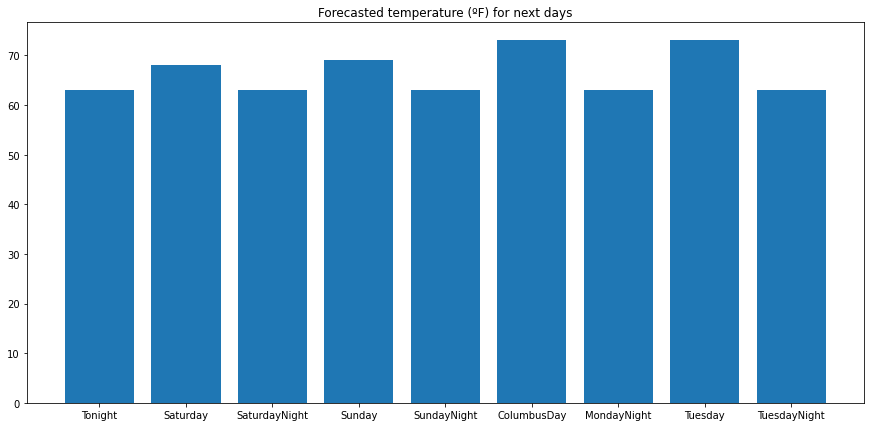

In [19]:
# Visualizing some relevant information about forecast weather
plt.figure(figsize = (15, 7))
plt.bar(weather_df["period"], weather_df["temp_num"])
plt.title("Forecasted temperature (ºF) for next days")

In [20]:
# Storing extracted information for further analysis
collection.insert_many(weather_df.to_dict(orient = "row"))